In [1]:

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import sys

sys.path.append("scripts/")
import scripts.conf as conf
import scripts.oncotree
conf.config_params()
oncotree = scripts.oncotree.Oncotree()


os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

### First, create the source data

In [9]:
if not(os.path.exists("source_data/model_selection_information.tsv")):
    !python scripts/create_table_stats_models.py source_data/model_selection_information.tsv

### Figure Extended data SXXX, Load data

In [3]:
def assign_quartile(row,a,b,d_values):
    if row[a] >= d_total[a] and row[b] >= d_values[b]:
        return "Other"
    if row[a] >= d_total[a] and row[b] < d_values[b]:
        return "Other"
    if row[a] < d_total[a] and row[b] >= d_values[b]:
        return "Q1"
    if row[a] < d_total[a] and row[b] < d_values[b]:
        return "Other"

In [4]:
data = pd.read_csv("source_data/model_selection_information.tsv",sep="\t")
selected = data[data["selected"]]

d_total = {}
d_total["discovery_index"]=np.percentile(selected["discovery_index"].values,50)
d_total["mean_fscore50"]=np.percentile(selected["mean_fscore50"].values,50)

d_values = {"discovery_index":np.nanmedian(selected["discovery_index"].values),"mean_fscore50":np.nanmedian(selected["mean_fscore50"].values)} 
data["quartile_di_vs_fscore"] = data.apply(lambda row: assign_quartile(row,"discovery_index","mean_fscore50",d_values),axis=1)
selected = data[data["selected"]]

# Extended Figure SXXX

In [5]:
def plot_nmuts_vs_performance(df,x_column,y_column,y_error_c,selected_column,cancer_specific,xlabel = "", ylabel = "", title='Mutational discovery index and boostdm performance', highlight_genes=None, density=None, saveplot=False,name_plot=""):
    highlight_gene_ttypes_coord = {}
    highlight_gene_ttypes_role = {}
    x, y, y_error, s, c, role, selected,ec = [], [], [], [], [], [], [], []
    for i,r in df.iterrows():
        if (cancer_specific and is_cancer_specific(r["ttype"])) or not(cancer_specific):
            x.append(r[x_column])
            y.append(r[y_column])
            y_error.append([r[y_column]-r[y_error_c[0]],r[y_error_c[1]]-r[y_column]])
            role.append(r["ROLE"])
            sel = r[selected_column]
            selected.append(sel)
            
            if sel:
                s.append(50)
                c.append(conf.dict_colors_role[r["ROLE"]])
                ec.append("black")
            else:
                s.append(25)
                c.append("grey")
                ec.append("grey")
        
        if highlight_genes is not None:
                k=(r["ttype"],r["gene"])
                if (r["ttype"],r["gene"]) in highlight_genes:
                    highlight_gene_ttypes_coord[k] = y[-1], x[-1]
                    highlight_gene_ttypes_role[k] = r["ROLE"]
                    print(f'{r["gene"]}: {r["ttype"]}: discovery index: {y[-1]} performance f-score50 {x[-1]}')

    fig, ax = plt.subplots(figsize=(6.5, 7))
    gs = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[15,2], height_ratios=[2, 15])
    gs.update(hspace=0.0, wspace=0.00)

    ax0 = plt.subplot(gs[0]) # density top
    ax1 = plt.subplot(gs[1]) # null
    ax2 = plt.subplot(gs[2], sharex=ax0) # scatter
    ax3 = plt.subplot(gs[3], sharey=ax2) # density

    # ax0: density plot: oncogenes vs tumor suppressors
    
    
    bandwidth = 0.03
    alpha = 0.25
    x_lof = [u for i, u in enumerate(x) if role[i] == 'LoF' ]
    x_act = [u for i, u in enumerate(x) if role[i] == 'Act']
    x_amb = [u for i, u in enumerate(x) if (role[i] == 'ambiguous' or str(role[i]) == "nan") ]

    y_lof = [u for i, u in enumerate(y) if role[i] == 'LoF' ]
    y_act = [u for i, u in enumerate(y) if role[i] == 'Act']
    y_amb = [u for i, u in enumerate(y) if role[i] == 'ambiguous' ]

    bandwidth = 0.2
    alpha = 0.25
    
    # ax1: scatter plot

    

    # x 
    x_lof = [u for i, u in enumerate(x) if role[i] == 'LoF' and selected[i]]
    x_act = [u for i, u in enumerate(x) if role[i] == 'Act' and selected[i]]
    x_amb = [u for i, u in enumerate(x) if (role[i] == 'ambiguous' or str(role[i]) == "nan") and selected[i]]
    x_nonsel = [u for i, u in enumerate(x) if not(selected[i])]
    # y 
    y_lof = [u for i, u in enumerate(y) if role[i] == 'LoF' and selected[i]]
    y_act = [u for i, u in enumerate(y) if role[i] == 'Act' and selected[i]]
    y_amb = [u for i, u in enumerate(y) if role[i] == 'ambiguous' and selected[i]]
    y_nonsel = [u for i, u in enumerate(y) if not(selected[i])]
    
   
    # y error
    y_error_lof = [u for i, u in enumerate(y_error) if role[i] == 'LoF' and selected[i]]
    y_error_act = [u for i, u in enumerate(y_error) if role[i] == 'Act'  and selected[i] ]
    y_error_amb = [u for i, u in enumerate(y_error) if (role[i] == 'ambiguous' or str(role[i]) == "nan")  and selected[i]]
    y_error_nonsel = [u for i, u in enumerate(y_error) if not(selected[i])]
    
    ax2.scatter(x,y,s=s,c=c,alpha=0.9,edgecolors=ec,lw=1.)
    scatter_kwargs = {"alpha":1.,"markeredgecolor":"black","markeredgewidth":0.5,"markersize":0}
    elinew=0.3
    
    ax2.errorbar(x_lof, y_lof,  yerr=np.array(y_error_lof).T, capsize=0 ,elinewidth=elinew,fmt='o',color=conf.dict_colors_role["LoF"],**scatter_kwargs)
    ax2.errorbar(x_act, y_act, yerr=np.array(y_error_act).T,  capsize=0 ,elinewidth=elinew,fmt='o',color=conf.dict_colors_role["Act"],**scatter_kwargs)
    ax2.errorbar(x_amb, y_amb, yerr=np.array(y_error_amb).T,  capsize=0 ,elinewidth=elinew,fmt='o',color=conf.dict_colors_role["ambiguous"],**scatter_kwargs)
    scatter_kwargs = {"alpha":0.5,"markeredgewidth":0.0,"markersize":0}
    elinew=0.3
    ax2.errorbar(x_nonsel, y_nonsel,  capsize=0 ,elinewidth=elinew ,fmt='o',color="grey", yerr=np.array(y_error_nonsel).T,**scatter_kwargs) #  

    
    
    #ax2.hlines(0.8, 0, 1, color='grey', linestyles='dashed' , lw= 1.0) 
    ax2.set_ylabel(ylabel,fontsize=12)
    ax2.set_xlabel(xlabel,fontsize=12)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)


    if highlight_genes is not None:
        for k, v in highlight_gene_ttypes_coord.items():
            ax2.text(v[1] + np.random.uniform(low=0, high=0.05, size=1), v[0], 
                     f'{k[1]} ({k[0]})',fontsize=10)
            ax2.scatter([v[1]], [v[0]], 
                        s=25, 
                        marker='o', color=conf.dict_colors_role[highlight_gene_ttypes_role[k]], edgecolors='black',lw=2)

    ax0.axis('off')
    ax1.axis('off')
    ax3.axis('off')
    ax2.set_xscale('log')
    #ax2.set_xlim(10,5000)
    from matplotlib.ticker import FuncFormatter
    formatter = FuncFormatter(lambda x, pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(x), 0)))).format(x))
    ax2.xaxis.set_major_formatter(formatter)
    ax2.hlines(0.8, ax2.get_xlim()[0], ax2.get_xlim()[1], color='grey', linestyles='dashed' , lw= 1.0) 
    
    if density is None:
        ax0.set_title(title)
    else:
        ax2.set_title(title)

    if "log" in x_column:
        ax2.set_xticklabels([int(2**x) for x in ax2.get_xticks()])

   
    
    
    ax2.set_ylim(0.5,1.05)
    # create legend
    
    markers = [plt.Line2D([0,0],[0,0],color=conf.dict_colors_role["LoF"], marker='o', linestyle=''),
               plt.Line2D([0,0],[0,0],color=conf.dict_colors_role["Act"], marker='o', linestyle=''),
               plt.Line2D([0,0],[0,0],color=conf.dict_colors_role["Amb"], marker='o', linestyle='solid',lw=1.,markeredgecolor="black"),
               plt.Line2D([0,0],[0,0],color="grey", marker='o', linestyle='')]
    ax2.legend(markers, [f"{len(x_lof)} tumor supressor models",f"{len(x_act)} oncogene models",f"{len(x_amb)} ambiguous models",f"{len(x_nonsel)} non-selected models"], 
               numpoints=1,loc =(0.7,0.05),facecolor=None )
    
    if saveplot:
        plt.savefig(f'./raw_plots/{name_plot}.pdf', dpi=800,bbox_inches="tight")
        plt.savefig(f'./raw_plots/{name_plot}.png', dpi=800,bbox_inches="tight")

    plt.show()
    
    return y

def is_specific(gene, ttype, model_dict):
    """
    asserts whether the model employed for gene-ttype
    is specific -- has been fitted with mutations 
    strictly from the gene-ttype -- or not.

    it uses model_dict, an instance externally defined
    with the boostdm models
    """

    model = model_dict.get((ttype, gene), None)
    if (ttype, gene) == model:
        return True
    else:
        return False

    
    
def is_cancer_specific(ttype):
    ttypes=oncotree.get_ttypes(ttype)
    if len(ttypes) == 1 and ttypes[0] == ttype:
        return True
    return False

RB1: BLCA: discovery index: 0.9663865546218487 performance f-score50 153
TP53: COREAD: discovery index: 0.9114349922831072 performance f-score50 827
CTNNB1: HC: discovery index: 0.9529945999018165 performance f-score50 446


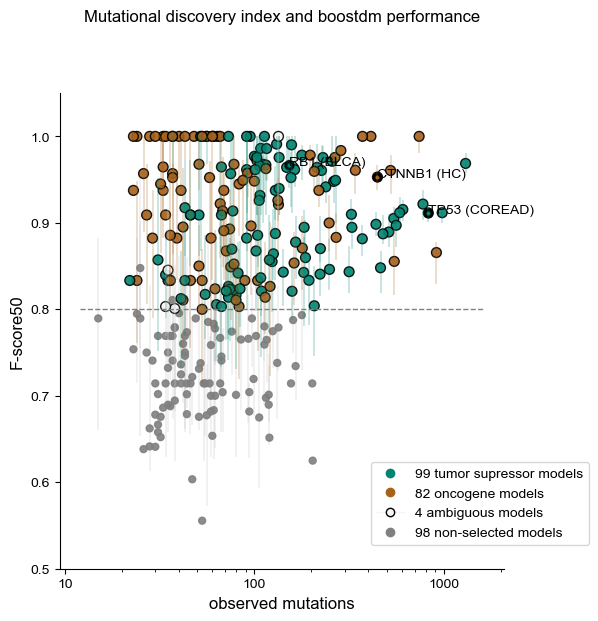

In [6]:
_=plot_nmuts_vs_performance(data.drop_duplicates(),y_column="mean_fscore50",x_column="n_muts",y_error_c=("up_fscore50","dn_fscore50"),cancer_specific=True,selected_column="selected",
                             ylabel="F-score50",xlabel="observed mutations",highlight_genes=[('COREAD', 'TP53'), ('BLCA', 'RB1'),  ('HC', 'CTNNB1')],saveplot=True,name_plot="n_muts_vs_performance")

# Extended Figure XXX

In [3]:
#if not(os.path.exists("source_data/ratio_drivers_per_gene.tsv")):
    !python scripts/compute_ratio_observed_drivers_per_model.py source_data/ratio_drivers_per_gene.tsv

Number of unique mutatoins... 55729


### Extended Figure S , prepare data

In [4]:
ratios = pd.read_csv("source_data/ratio_drivers_per_gene.tsv",sep="\t")
r = ratios[ratios["unique_mutations"]>14].sample(50,random_state=1).sort_values("ratio_drivers",ascending=False)

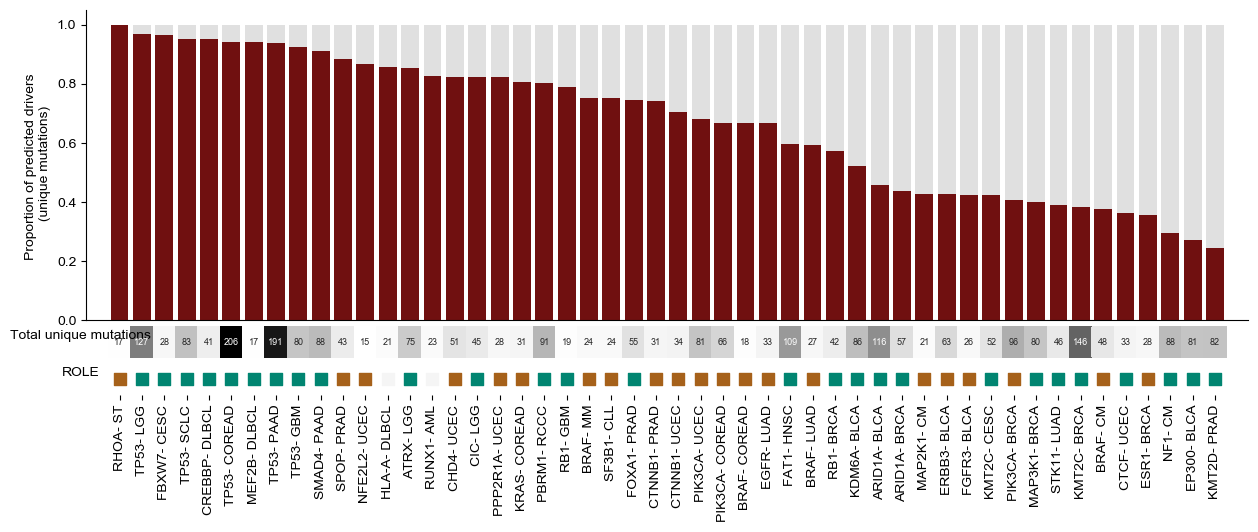

In [5]:
fig,_ = plt.subplots(figsize=(15,5))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=3, height_ratios=[10, 1, 1])
gs.update(hspace=0.05, wspace=0)
ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1]) 
ax2 = plt.subplot(gs[2]) 
r["label"] = r.apply(lambda row: row["gene"] + "- "+ row["CANCER_TYPE"],axis=1)
labels=list(r.label)
r["m"] = 1.
sns.barplot(data=r,x="label",y="m",color="#E0E0E0",ax=ax,order=labels)
sns.barplot(data=r,x="label",y="ratio_drivers",color="#800000",ax=ax,order=labels)

# barplot mutations total
e=r.set_index(["gene","CANCER_TYPE"])[["unique_mutations"]].T
e.columns=labels
sns.heatmap(e,cmap="Greys",annot=True, fmt="d",ax=ax1,cbar=False, annot_kws={"fontsize":6.5})

r["color"] = r.apply(lambda row: conf.dict_colors_role[row["ROLE"]],axis=1)
c=r.set_index(["gene","CANCER_TYPE"])[["color"]].T
c.columns=labels
for i in range(len(labels)):
    ax2.scatter(x=i,y=0,marker="s",color=c[labels[i]],s=80)
    

ax.set_xticks([])
ax1.set_xticks([])
#ax2.set_xticks([])
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels,rotation=90)
ax.set_xlim(ax.get_xlim()[0]-1,ax.get_xlim()[1]+1)
ax1.set_xlim(ax.get_xlim()[0]+.5,ax.get_xlim()[1]+0.5)
ax2.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])


ax2.spines['top'].set_linewidth(0.0)
ax2.spines['right'].set_linewidth(0.0)
ax2.spines['left'].set_linewidth(0.0)
ax2.spines['bottom'].set_linewidth(0.0)

ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)


ax.set_ylabel("Proportion of predicted drivers \n (unique mutations)")
ax1.set_ylabel("Total unique mutations",rotation=0)
ax2.set_ylabel("ROLE",rotation=0)

ax1.set_yticks([])
ax2.set_yticks([])
plt.savefig(f'./raw_plots/examples_genes_driver_proportion.pdf', dpi=800,bbox_inches="tight")
plt.show()


